# Introduction to Machine Learning and Deep Learning

### Acknowledgements

The content of this notebook was originally created by Nils Eckstein, Julia Buhmann, and Jan Funke for the 2021 DL@MBL course in Woods Hole, and later chopped up and modified by Florian Jug for the 2021 course DL4MIA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Dense

2021-11-21 11:06:20.896633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-21 11:06:20.896675: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Let's get the MNIST data...

This is one of the most famous and most frequently used datasets of small images of hand-written digits and their corresponding ground-truth classes.

In this exercise we will learn to predict the correct class given an image of a hand-written digit.

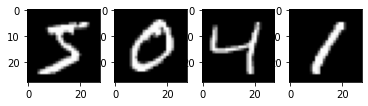

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

"""
Returns:
2 tuples:

x_train, x_test: uint8 array of grayscale image data with shape (num_samples, 28, 28).
y_train, y_test: uint8 array of digit labels (integers in range 0-9) with shape (num_samples,).
"""

# Show example data
plt.subplot(1,4,1)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
plt.show()

### Let's create a network we'd like to train...

The one currently implemented in the cell below will turn out to not work so well. Run it anyways, but then come back here and start playing with changing the network architecture and hopefully find a better working model for the task at hand!

In [3]:
input_shape = (x_train.shape[1], x_train.shape[2], 1)

cnn_model = Sequential()
cnn_model.add(Conv2D(filters=1,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(filters=2,
                     kernel_size=(3, 3),
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(10, activation='softmax')) # softmax for classification

cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adagrad', # adaptive optimizer (still similar to SGD)
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 1)         10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 1)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 2)         20        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 2)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 64)                3

2021-11-21 11:06:22.528313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-21 11:06:22.528349: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-21 11:06:22.528367: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (capableturing-34a32): /proc/driver/nvidia/version does not exist
2021-11-21 11:06:22.528580: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Brind data in the shape we need during training...

In particular:
 * add an channel dimension to train and test data
 * normalize the pixel intensities to [0,1]
 * transform the ground-truth label from a digit (0, ..., 9) to one-hot encoded vectors. (Example: the one-hot encoded vector for digit `3` will become `0001000000`, etc.)

In [4]:
from tensorflow.keras.utils import to_categorical

# add a channel dimension to the images
x_train = x_train.reshape(x_train.shape[0],
                          x_train.shape[1],
                          x_train.shape[2],
                          1)
x_test = x_test.reshape(x_test.shape[0],
                        x_test.shape[1],
                        x_test.shape[2],
                        1)

# rescale intensities to be between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert the labels into one-hot encodings
y_train_onehot = to_categorical(y_train, 10)
y_test_onehot = to_categorical(y_test, 10)

### Train the network...

Note that we decided on some things like the number of epochs, or a batch_size... what is all this? Could we have chosen other values? What would change?

In [5]:
cnn_model.fit(x_train,
             y_train_onehot,
             steps_per_epoch=1000,
             batch_size=32,
             epochs=3,
             verbose=1,
             validation_data=(x_test, y_test_onehot)) # never actually validate using test data!

Epoch 1/3
1000/1000 [==============================] - 18s 17ms/step - loss: 2.2997 - accuracy: 0.1560 - val_loss: 2.2970 - val_accuracy: 0.1875
Epoch 2/3
1000/1000 [==============================] - 17s 17ms/step - loss: 2.2952 - accuracy: 0.1845 - val_loss: 2.2929 - val_accuracy: 0.1859
Epoch 3/3
1000/1000 [==============================] - 17s 17ms/step - loss: 2.2911 - accuracy: 0.1860 - val_loss: 2.2881 - val_accuracy: 0.1931


MNIST test set accuracy: 0.1931000053882599
CNN predictions: 3, 3, 1, 3


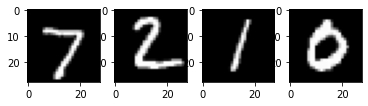

In [6]:
score = cnn_model.evaluate(x_test, y_test_onehot, verbose=0)
print('MNIST test set accuracy:', score[1])

# visualize some test data and network output
y_predict = cnn_model.predict(x_test, verbose=0)
y_predict_digits = [np.argmax(y_predict[i]) for i in range(y_predict.shape[0])]


plt.subplot(1,4,1)
plt.imshow(x_test[0,:,:,0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,2)
plt.imshow(x_test[1,:,:,0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,3)
plt.imshow(x_test[2,:,:,0], cmap=plt.get_cmap('gray'))
plt.subplot(1,4,4)
plt.imshow(x_test[3,:,:,0], cmap=plt.get_cmap('gray'))

print("CNN predictions: {0}, {1}, {2}, {3}".format(y_predict_digits[0],
                                                   y_predict_digits[1],
                                                   y_predict_digits[2],
                                                   y_predict_digits[3]))

### Show a few more examples, so we also see some of the errors...

Errors: 31


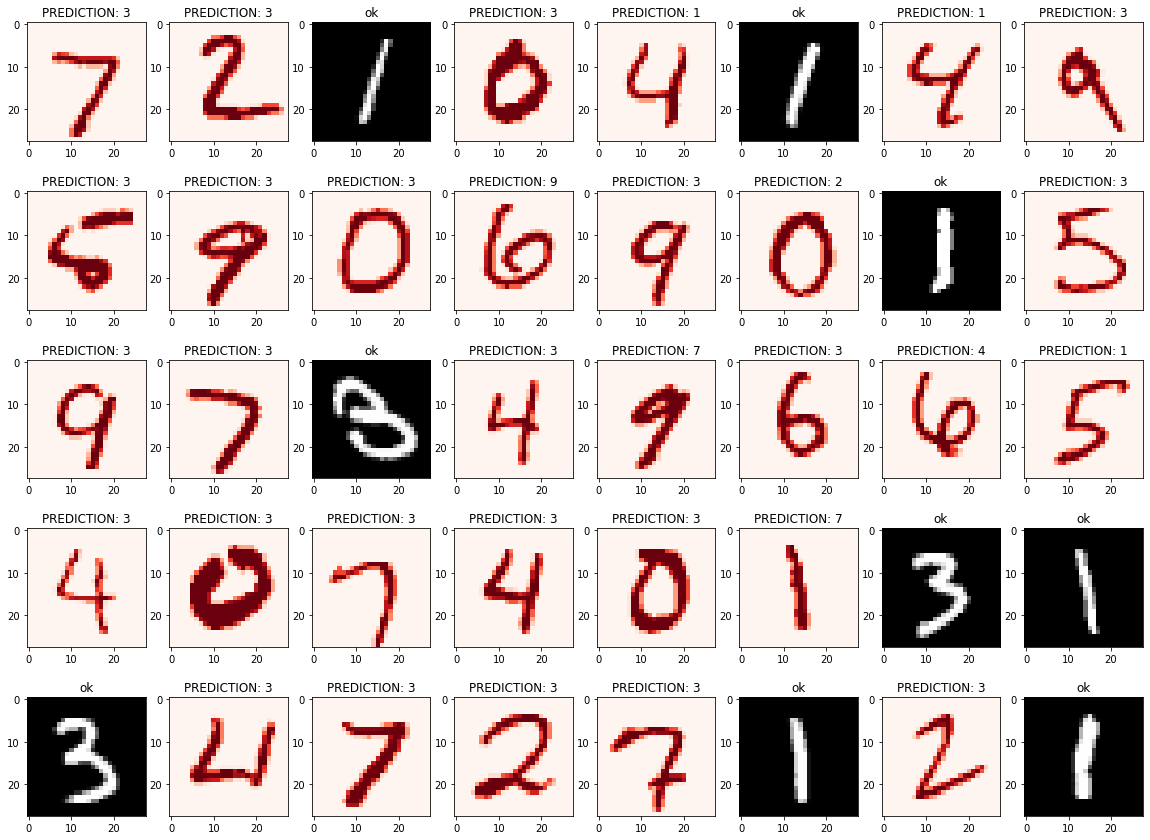

In [7]:
fig, axes = plt.subplots(5, 8, figsize=(20,15))
errors=0
for i in range(40):
    if y_predict_digits[i]==y_test[i]:
        axes.flatten()[i].imshow(x_test[i,:,:,0], cmap=plt.get_cmap('gray'))
        axes.flatten()[i].set_title('ok')
    else:
        axes.flatten()[i].imshow(x_test[i,:,:,0], cmap=plt.get_cmap('Reds'))
        axes.flatten()[i].set_title('PREDICTION: %s'%(y_predict_digits[i]))
        errors+=1
        
print("Errors: %d"%errors)

### NEXT: improve the network, maybe also the network training, and reduce the test errors...

Another fun exercise might be to try to find the smallest network (fewest trainable parameters) that still leads to an test error smaller 15%...

**Note:** You will find out that if you modify the network, TensorFlow might hick up... likely you want to restart the kernel every time you make changes to the network...

### Once you're done, please anser these question:

 * What did you play with, what made the biggest difference?
 * How many parameters did you end up unsing?
 * How long did you train the network?
 * What was the best test-error you got overall?